In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [24]:
csv_data_json = []
# creating the correct csv
class_path = '/kaggle/input/wikiart-gangogh-creating-art-gan/images/'
for dirname in os.listdir(class_path):
    dir_path = os.path.join(class_path, dirname)
    images_in_dir = os.listdir(dir_path)
    for filename in images_in_dir:
        csv_data_json.append({
            "class_name": dirname,
            "image_path": os.path.join(class_path, dirname, filename),
        })

dataset_idx = pd.DataFrame(csv_data_json)
unique_classes = dataset_idx["class_name"].unique()
dataset_idx["labels"] = dataset_idx["class_name"].map({val: idx for idx, val in enumerate(unique_classes)})
_ = dataset_idx.to_csv("/kaggle/working/WikiArt.csv", sep='\t', encoding='utf-8')
_labels = {val: idx for idx, val in enumerate(unique_classes)}

In [25]:
_labels = {val: idx for idx, val in enumerate(unique_classes)}
print(_labels)

{'genre-painting': 0, 'symbolic-painting': 1, 'nude-painting-nu': 2, 'flower-painting': 3, 'animal-painting': 4, 'religious-painting': 5, 'figurative': 6, 'marina': 7, 'abstract': 8, 'still-life': 9, 'portrait': 10, 'cityscape': 11, 'mythological-painting': 12, 'landscape': 13}


In [4]:
def load_and_preprocess_image(image_path):
    try:
        img = image.load_img(image_path, target_size=(300, 300))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        return img_array
    except Exception as e:
        print(f"An exception occurred while loading image: {e}")
        return None

In [2]:
dataset = pd.read_csv("/kaggle/input/wikiart/WikiArt (1) - WikiArt (1).csv")
labels = [8,11,10,13,4] # selected labels, these labels are the most visually different
newLabels = {
    8: 0, # abstract
    11: 1, # cityscape
    10: 2, # portrait
    13: 3, # landscape
    4: 4, # animal-painting
}
display(dataset.info())
limited_dataset = None

for label in labels:
    label_items = dataset[dataset['labels'] == label].head(2000)
    limited_dataset = pd.concat([limited_dataset, label_items])
limited_dataset['labels'] = limited_dataset['labels'].map(newLabels)
limited_dataset.drop(columns=['Unnamed: 0'], inplace=True)
limited_dataset.reset_index(drop=True, inplace=True)
display(limited_dataset)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96014 entries, 0 to 96013
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  96014 non-null  int64 
 1   image_path  96014 non-null  object
 2   labels      96014 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 2.2+ MB


None

,image_path,labels
0,/kaggle/input/wikiart-gangogh-creating-art-gan...,0
1,/kaggle/input/wikiart-gangogh-creating-art-gan...,0
2,/kaggle/input/wikiart-gangogh-creating-art-gan...,0
3,/kaggle/input/wikiart-gangogh-creating-art-gan...,0
4,/kaggle/input/wikiart-gangogh-creating-art-gan...,0
...,...,...
9794,/kaggle/input/wikiart-gangogh-creating-art-gan...,4
9795,/kaggle/input/wikiart-gangogh-creating-art-gan...,4
9796,/kaggle/input/wikiart-gangogh-creating-art-gan...,4
9797,/kaggle/input/wikiart-gangogh-creating-art-gan...,4


In [5]:
images = []
labels = []

for idx, row in limited_dataset.iterrows():
    img_path = row['image_path']
    label = row['labels']
    img_array = load_and_preprocess_image(img_path)
    if img_array is not None:
        images.append(img_array)
        labels.append(label)

# Convert lists to NumPy arrays
images = np.concatenate(images)
labels = np.array(labels)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (99962094 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


An exception occurred while loading image: image file is truncated (52 bytes not processed)


In [6]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print("Shapes - X_train:", X_train.shape, "X_test:", X_test.shape, "y_train:", y_train.shape, "y_test:", y_test.shape)

Shapes - X_train: (7838, 300, 300, 3) X_test: (1960, 300, 300, 3) y_train: (7838,) y_test: (1960,)


In [7]:
del images # clearing memory
del labels

In [8]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    
)
datagen.fit(X_train)

In [9]:
base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(300, 300, 3))

234698864/234698864 [==============================] - 10s 0us/step


In [10]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.05))(x)
x = Dropout(0.6)(x)

predictions = Dense(5, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [11]:
for layer in base_model.layers:
    layer.trainable = False
    
for layer in base_model.layers[-30:]:
    layer.trainable = True
    
model.compile(optimizer=Adam(lr=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [12]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)


history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping]
)

loss, accuracy = model.evaluate(X_test, y_test)

Epoch 1/10
245/245 [==============================] - 195s 698ms/step - loss: 6.1567 - accuracy: 0.8040 - val_loss: 0.6932 - val_accuracy: 0.8383
Epoch 2/10
245/245 [==============================] - 174s 709ms/step - loss: 0.6843 - accuracy: 0.8525 - val_loss: 0.6588 - val_accuracy: 0.8526
Epoch 3/10
245/245 [==============================] - 164s 670ms/step - loss: 0.6017 - accuracy: 0.8609 - val_loss: 0.5478 - val_accuracy: 0.8719
Epoch 4/10
245/245 [==============================] - 175s 716ms/step - loss: 0.5496 - accuracy: 0.8811 - val_loss: 0.6492 - val_accuracy: 0.8398
Epoch 5/10
245/245 [==============================] - 166s 676ms/step - loss: 0.5015 - accuracy: 0.8844 - val_loss: 0.5947 - val_accuracy: 0.8602
Epoch 6/10
62/62 [==============================] - 14s 220ms/step - loss: 0.5478 - accuracy: 0.8719


{'loss': [6.156745910644531, 0.6843165159225464, 0.6017402410507202, 0.5495574474334717, 0.5014736652374268, 0.48313888907432556], 'accuracy': [0.8040316700935364, 0.8525133728981018, 0.8609338998794556, 0.8810921311378479, 0.8844093084335327, 0.8929573893547058], 'val_loss': [0.6931515336036682, 0.6588460206985474, 0.5478007197380066, 0.6491521596908569, 0.5947186350822449, 0.8113216757774353], 'val_accuracy': [0.8382652997970581, 0.8525510430335999, 0.8719387650489807, 0.8397959470748901, 0.8602041006088257, 0.8260204195976257]}


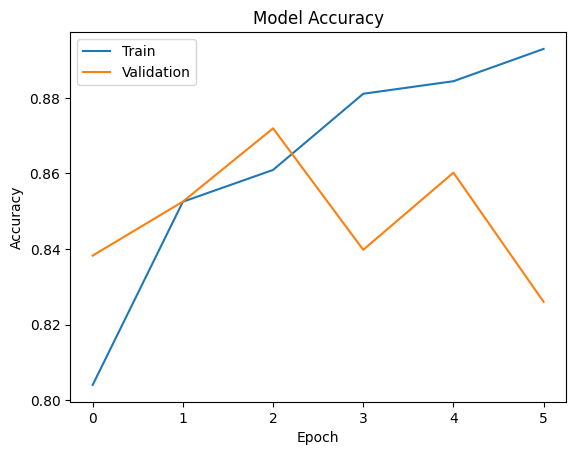

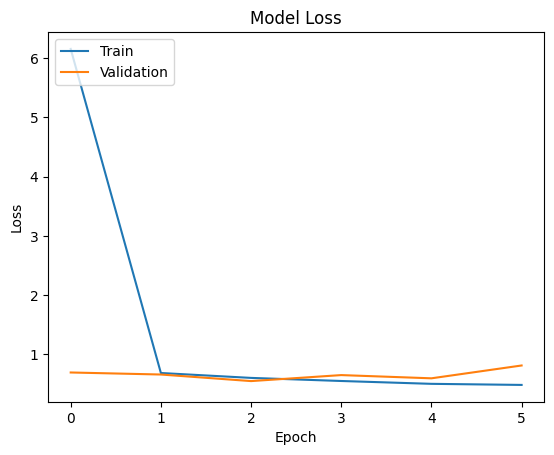

In [13]:
import matplotlib.pyplot as plt


print(history.history)
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [18]:
from sklearn.metrics import confusion_matrix

predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

62/62 [==============================] - 13s 216ms/step


In [21]:
conf_matrix = confusion_matrix(y_test, predicted_labels, labels=[0,1,2,3,4])

[[1.5860237e-02 3.8136142e-01 5.0078500e-03 5.7303101e-01 2.4739504e-02]
 [9.9773186e-01 1.9957537e-04 2.8231614e-05 6.1411753e-05 1.9788824e-03]
 [1.3564042e-03 4.6242781e-02 8.4665860e-04 9.4639373e-01 5.1603653e-03]
 ...
 [9.9832088e-01 9.1670058e-04 4.8603350e-05 2.7248633e-04 4.4133884e-04]
 [9.3567961e-01 2.9251222e-02 4.8344731e-03 1.1352749e-02 1.8881934e-02]
 [7.8500359e-04 7.2436668e-03 1.9699034e-04 9.8988008e-01 1.8943519e-03]]
Confusion Matrix:
[[381   8   2   5  17]
 [ 10 329   5  44   5]
 [  4   0 382   2   7]
 [ 17  54   1 308  17]
 [ 31   2   7  13 309]]


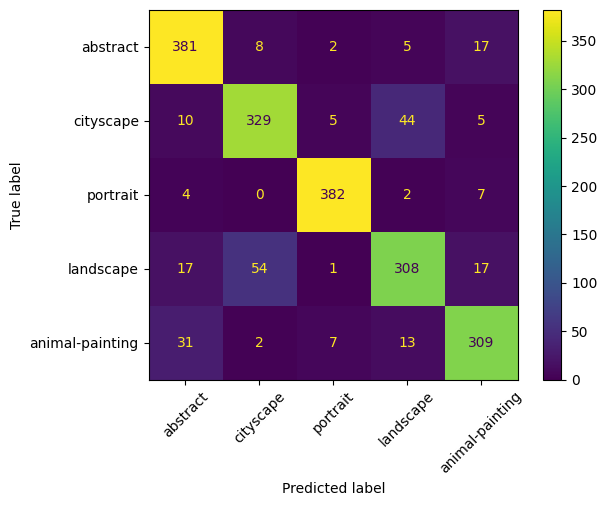

In [26]:
from sklearn.metrics import ConfusionMatrixDisplay
# newLabels = {
#     8: 0, # abstract
#     11: 1, # cityscape
#     10: 2, # portrait
#     13: 3, # landscape
#     4: 4, # animal-painting
# }
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=["abstract", "cityscape", "portrait", "landscape", "animal-painting"])
disp.plot(xticks_rotation=45)

In [15]:
print(loss, accuracy)

0.5478007197380066 0.8719387650489807


In [16]:
model.save('my_model.h5')
model_json = model.to_json()
with open('model_architecture.json', 'w') as json_file:
    json_file.write(model_json)

model.save_weights('model_weights.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [28]:
from IPython.display import FileLink
FileLink(r'my_model.h5')

/kaggle/working/my_model.h5